# 1. SETTINGS

In [14]:
# libraries
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# garbage collection
import gc
gc.enable()

In [3]:
# pandas options
pd.set_option("display.max_columns", None)

In [4]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
# random settings
seed = 42

# 2. PREPARATIONS

In [6]:
# import data
train = pd.read_csv("../data/prepared/train_full_nona_onehot.csv")
test  = pd.read_csv("../data/prepared/test_full_nona_onehot.csv")
y     = pd.read_csv("../data/prepared/y_full_nona_onehot.csv")

In [7]:
# extract target
y = y["TARGET"]

In [8]:
# exclude features
excluded_feats = ["SK_ID_CURR"]
features = [f for f in train.columns if f not in excluded_feats]

In [9]:
# check dimensions
print(train[features].shape)
print(test[features].shape)

(307511, 1844)
(48744, 1844)


In [10]:
### PARAMETERS

# parallel settings
cores = 16

# learner settings
metric   = "auc"
verbose  = 250
stopping = 300

# CV settings
num_folds = 10
shuffle   = True

# lightGBM
gbm = lgb.LGBMClassifier(n_estimators     = 10000,
                         learning_rate    = 0.004,
                         num_leaves       = 80,
                         colsample_bytree = 0.8,
                         subsample        = 0.9,
                         max_depth        = 7,
                         reg_alpha        = 0.3,
                         reg_lambda       = 0.3,
                         min_split_gain   = 0.01,
                         min_child_weight = 2,
                         random_state     = seed,
                         num_threads      = cores)

# 3. CROSS-VALIDATION

In [11]:
# data partitinoing
folds = StratifiedKFold(n_splits = num_folds, random_state = seed, shuffle = shuffle)

# placeholders
valid_aucs_cv = np.zeros(num_folds) 
test_preds_cv = np.zeros(test.shape[0])

In [12]:
### CROSS-VALIDATION LOOP
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y)):
    
    # data partitioning
    trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]
    
    # train lightGBM
    gbm = gbm.fit(trn_x, trn_y, 
                  eval_set = [(trn_x, trn_y), (val_x, val_y)], 
                  eval_metric = metric, 
                  verbose = verbose, 
                  early_stopping_rounds = stopping)
    
    # save number of iterations
    num_iter_cv = gbm.best_iteration_
    
    # predictions
    valid_preds_cv = gbm.predict_proba(val_x, num_iteration = num_iter_cv)[:, 1]
    valid_aucs_cv[n_fold] = roc_auc_score(val_y, valid_preds_cv)
    test_preds_cv += gbm.predict_proba(test[features], num_iteration = num_iter_cv)[:, 1] / folds.n_splits
    
    # print performance
    print("----------------------")
    print("Fold%2d AUC: %.6f" % (n_fold + 1, valid_aucs_cv[n_fold]))
    print("----------------------")
    print("")

    # clear memory
    del trn_x, trn_y, val_x, val_y
    gc.collect()
    
# print overall performance    
print("Cross-Validation AUC score %.6f" % np.mean(valid_aucs_cv))

# RESULTS   
# no card, old features (560):            0.786941 | 0.783
# no card, new features (694):            0.788893 | 0.783
# with card, new features (1072):         0.790123 | 0.787
# with card and kernel features (1109):   0.790053 | 
# card, kernel, factorize, no na (978):   0.790803 | 
# card, kern, fac, nona, adummy (1193):   0.791321 |
# full data, one-hot ecoding (1844):      0.791850 |
# full data, one-hot, extra sums (2486):  0.791880 | 0.789 | 10f = 0.79261
# full, one-hot, sums, buroscore (2501):  0.791761 | 
# full, one-hot, clean, buroscore (1826): 0.791867 |
# last data + ext, age ratios (1828):     0.791808 |

Training until validation scores don't improve for 300 rounds.
[250]	training's auc: 0.769063	valid_1's auc: 0.755098
[500]	training's auc: 0.781274	valid_1's auc: 0.760417
[750]	training's auc: 0.796747	valid_1's auc: 0.767776
[1000]	training's auc: 0.812246	valid_1's auc: 0.775025
[1250]	training's auc: 0.826102	valid_1's auc: 0.780697
[1500]	training's auc: 0.838006	valid_1's auc: 0.784774
[1750]	training's auc: 0.84818	valid_1's auc: 0.787842
[2000]	training's auc: 0.856918	valid_1's auc: 0.790216
[2250]	training's auc: 0.864556	valid_1's auc: 0.791815
[2500]	training's auc: 0.871519	valid_1's auc: 0.793198
[2750]	training's auc: 0.878009	valid_1's auc: 0.794185
[3000]	training's auc: 0.884149	valid_1's auc: 0.795073
[3250]	training's auc: 0.889705	valid_1's auc: 0.795894
[3500]	training's auc: 0.895065	valid_1's auc: 0.79657
[3750]	training's auc: 0.900205	valid_1's auc: 0.79714
[4000]	training's auc: 0.905007	valid_1's auc: 0.797677
[4250]	training's auc: 0.909676	valid_1's auc: 

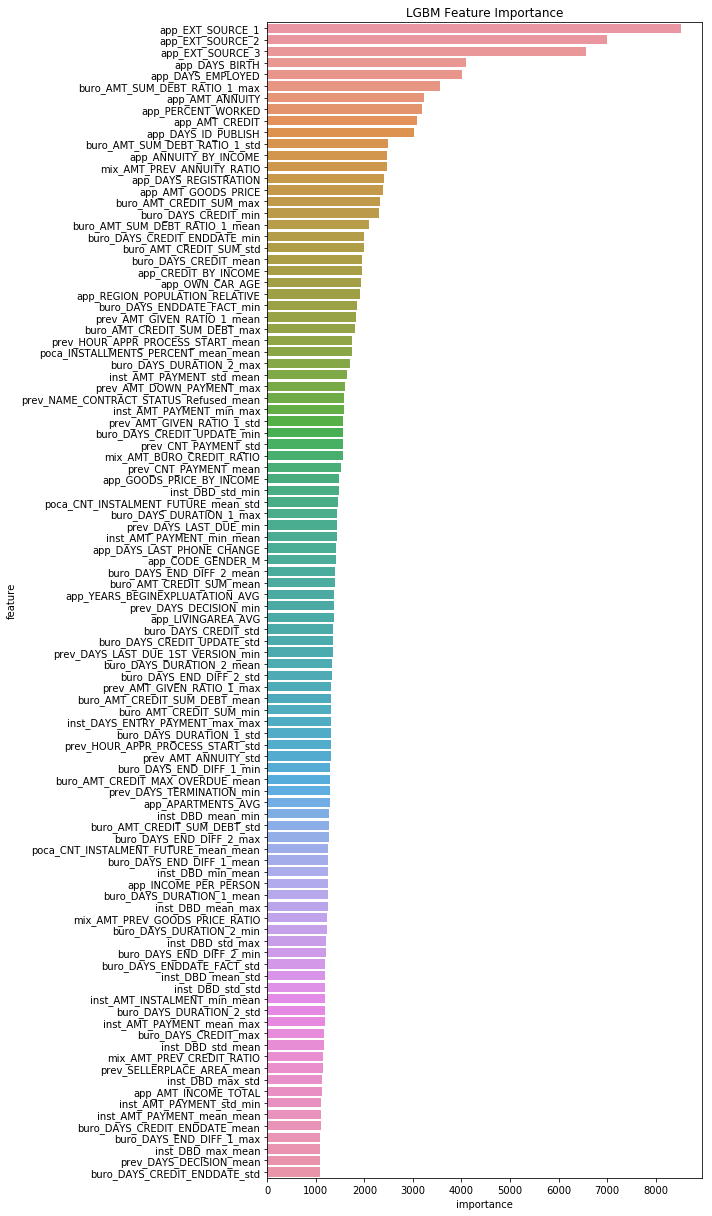

In [13]:
##### VARIABLE IMPORTANCE

# load variable importance
importance = pd.DataFrame()
importance["feature"] = features
importance["importance"] = gbm.feature_importances_
importance = importance.sort_values(by = "importance", ascending = False)[0:100]

# plot variable importance
plt.figure(figsize = (10, 17))
sns.barplot(x = "importance", y = "feature", data = importance)
plt.title('LGBM Feature Importance')
plt.tight_layout()

# 3. SUBMISSION

In [16]:
# create submission
test["TARGET"] = test_preds_cv
subm = test[["SK_ID_CURR", "TARGET"]]

# export CSV
subm.to_csv("../submissions/791850_bagged_lgb_30k_f1844.csv", index = False, float_format = "%.8f")